In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pyxdf

In [2]:
WPI_xdf_path = "../HCILab1-Group2.xdf"
CSL_xdf_path = "../CSL_02_10.xdf"

### View XDF Streams

In [3]:
def view_xdf_streams(xdf_path):
    data, header = pyxdf.load_xdf(xdf_path)
    print(header)

    for stream in data:
        stream_name = stream["info"]["name"][0]
        stream_id = stream["info"]["stream_id"]
        stream_srate = stream["info"]["effective_srate"]
        
        print(f'Stream {stream_name} (Stream ID: {stream_id} with sampling rate {stream_srate})')

In [4]:
view_xdf_streams(WPI_xdf_path)

Stream 2: Calculated effective sampling rate 16.8061 Hz is different from specified rate 30.0000 Hz.


{'info': defaultdict(<class 'list'>, {'version': ['1.0'], 'datetime': ['2024-10-02T09:56:29-0400']})}
Stream Unicorn_HCILab1 (Stream ID: 3 with sampling rate 250.259672269644)
Stream OBS_HCILab1 (Stream ID: 5 with sampling rate 30.000000310773537)
Stream Unicorn_HCILab2 (Stream ID: 6 with sampling rate 248.45314698232292)
Stream OBS_HCILab2 (Stream ID: 2 with sampling rate 16.806063108764057)
Stream Unicorn_CSL_LabPC (Stream ID: 4 with sampling rate 250.10225794756929)
Stream OBS_CSL_Laptop (Stream ID: 1 with sampling rate 29.999826143684412)


In [5]:
view_xdf_streams(CSL_xdf_path)

{'info': defaultdict(<class 'list'>, {'version': ['1.0'], 'datetime': ['2024-10-02T15:54:30+0200']})}
Stream OBS_CSL_Laptop (Stream ID: 1 with sampling rate 30.00000034617808)
Stream Unicorn_CSL_Laptop (Stream ID: 5 with sampling rate 250.24695369125143)
Stream Unicorn_CSL_LabPC (Stream ID: 3 with sampling rate 250.0992182634606)
Stream OBS_HCILab1 (Stream ID: 4 with sampling rate 30.00017602174776)
Stream Unicorn_HCILab1 (Stream ID: 2 with sampling rate 250.26306399489286)


WPI HCI Lab Streams:


Stream 2: Calculated effective sampling rate 16.8061 Hz is different from specified rate 30.0000 Hz.


Stream Unicorn_HCILab1 has 1016551 time stamps, starting with 3850.905082096096


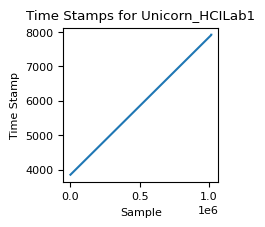

Stream OBS_HCILab1 has 138839 time stamps, starting with 3851.0584542938827
Stream OBS_HCILab1 with time series (UNIX) begins with 1727877389.049
Stream Unicorn_HCILab2 has 995082 time stamps, starting with 3850.055986775298


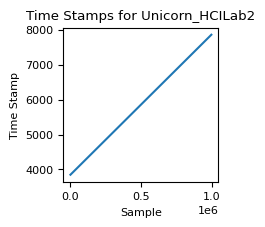

Stream OBS_HCILab2 has 81957 time stamps, starting with 3916.010756985914
Stream OBS_HCILab2 with time series (UNIX) begins with 1727877410.437
Stream Unicorn_CSL_LabPC has 1001948 time stamps, starting with 3851.1179012236107


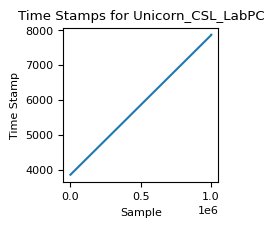

Stream OBS_CSL_Laptop has 135103 time stamps, starting with 3851.2276912086913
Stream OBS_CSL_Laptop with time series (UNIX) begins with 1727877390.424

CSL Lab Streams:
Stream OBS_CSL_Laptop has 123133 time stamps, starting with 4944235.853499064
Stream OBS_CSL_Laptop with time series (UNIX) begins with 1727877270.224
Stream Unicorn_CSL_Laptop has 1027149 time stamps, starting with 4944235.589834545


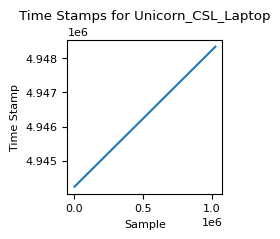

Stream Unicorn_CSL_LabPC has 1026328 time stamps, starting with 4944236.498566027


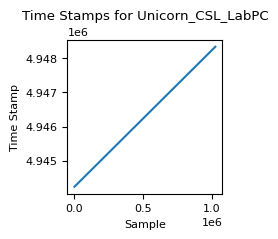

Stream OBS_HCILab1 has 123127 time stamps, starting with 4944236.018356754
Stream OBS_HCILab1 with time series (UNIX) begins with 1727877269.182
Stream Unicorn_HCILab1 has 1027164 time stamps, starting with 4944235.824412529


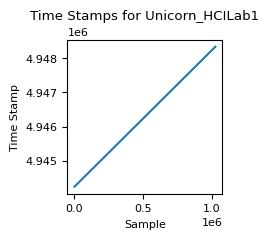

In [6]:
def examine_timestamps_length(xdf_path):
    data, header = pyxdf.load_xdf(xdf_path)
    
    for stream in data:
        stream_name = stream["info"]["name"][0]
        
        time_stamps = stream["time_stamps"]
        
        print(f'Stream {stream_name} has {len(time_stamps)} time stamps, starting with {time_stamps[0]}')
        
        time_series = stream["time_series"]
        if stream_name.startswith("OBS"):
            print(f"Stream {stream_name} with time series (UNIX) begins with {time_series[0][0]}")
        
        if "Unicorn" in stream_name:
            # plot the time stamps
            plt.rc('font', size=8)
            plt.figure(figsize=(2, 2))
            plt.plot(time_stamps)
            plt.xlabel('Sample')
            plt.ylabel('Time Stamp')
            plt.title(f"Time Stamps for {stream_name}")
            plt.show()

# Examine the length of all time stamps in each stream for both XDF files
print("WPI HCI Lab Streams:")
examine_timestamps_length(WPI_xdf_path)

print("\nCSL Lab Streams:")
examine_timestamps_length(CSL_xdf_path)

### Sync Streams!!

In [7]:
def sync_streams(data_streams_1, data_streams_2):
    
    """
    Sync the data by trimming time_stamp and time_series streams so that all EEG and Unicorn Streams begin at the same time
    
    Parameters:
    - data_streams_1: Stream data from WPI HCI Lab xdf file
    - data_streams_2: Stream data from CSL Lab xdf file
    """
    
    # Holds the 8 streams (4 OBS and 4 Unicorn)
    streams = {}
    
    # Create mappings of the 8 stream names to streams
    for stream in data_streams_1:
        stream_name = stream["info"]["name"][0]
        
        if stream_name in ["OBS_HCILab1", "Unicorn_HCILab1", "OBS_HCILab2", "Unicorn_HCILab2"]:
            streams[stream_name] = stream
            
    for stream in data_streams_2:
        stream_name = stream["info"]["name"][0]
        
        if stream_name in ["OBS_CSL_Laptop", "Unicorn_CSL_Laptop", "OBS_CSL_LabPC", "Unicorn_CSL_LabPC"]:
            streams[stream_name] = stream
    
    # From the OBS Video (when Chris says "Begin" and "Time's Up")
    start_unix_timestamp = 1727877596.924
    end_unix_timestamp = 1727881197.157
    duration = end_unix_timestamp - start_unix_timestamp
    frames = 250 * duration
    
    # Trim all the other streams based on the latest Unix timestamp
    # for OBS_stream_name, EEG_stream_name in [("OBS_HCILab1", "Unicorn_HCILab1"), ("OBS_HCILab2", "Unicorn_HCILab2"), ("OBS_CSL_Laptop", "Unicorn_CSL_Laptop"), ("OBS_CSL_LabPC", "Unicorn_CSL_LabPC")]:
    for OBS_stream_name, EEG_stream_name in [("OBS_HCILab1", "Unicorn_HCILab1"), ("OBS_HCILab2", "Unicorn_HCILab2"), ("OBS_CSL_Laptop", "Unicorn_CSL_Laptop")]:
        OBS_stream = streams[OBS_stream_name]
        EEG_stream = streams[EEG_stream_name]
        
        # First, find the LabRecorder timestamp in the OBS stream that corresponds to the start and end Unix timestamp
        OBS_unix_times = [ts[0] for ts in OBS_stream["time_series"]]
        start_OBS_index = np.searchsorted(OBS_unix_times, start_unix_timestamp)
        end_OBS_index = np.searchsorted(OBS_unix_times, end_unix_timestamp)
        
        start_labrecorder_timestamp = OBS_stream["time_stamps"][start_OBS_index]
        
        # Find the index in the EEG stream where this LabRecorder timestamp occurs
        start_EEG_index = np.searchsorted(EEG_stream["time_stamps"], start_labrecorder_timestamp)
        end_EEG_index = start_EEG_index + round(frames)
        
        # Trim all the data in the OBS and EEG streams based on this index
        OBS_stream["time_stamps"] = OBS_stream["time_stamps"][start_OBS_index:end_OBS_index]
        OBS_stream["time_series"] = OBS_stream["time_series"][start_OBS_index:end_OBS_index]
        EEG_stream["time_stamps"] = EEG_stream["time_stamps"][start_EEG_index:end_EEG_index]
        EEG_stream["time_series"] = EEG_stream["time_series"][start_EEG_index:end_EEG_index]
        
        print("For EEG Stream " + EEG_stream_name + ", start cutoff index is " + str(start_EEG_index) + " and end cutoff index is " + str(start_EEG_index + len(EEG_stream["time_stamps"])))
    
    return streams

In [8]:
# Load the XDF data for both labs
WPI_data_streams, WPI_header = pyxdf.load_xdf(WPI_xdf_path)
CSL_data_streams, CSL_header = pyxdf.load_xdf(CSL_xdf_path)

Stream 2: Calculated effective sampling rate 16.8061 Hz is different from specified rate 30.0000 Hz.


In [9]:
# Before syncing the streams, let's examine the time_stamps and time_series in both files
def print_time_stamps_and_series(data_streams):
    for stream in data_streams:
        stream_name = stream["info"]["name"][0]
        print(f'\nStream {stream_name} has {len(stream["time_stamps"])} time stamps and {len(stream["time_series"])} time series')
        
        if len(stream["time_stamps"]) > 0:
            print(f'Time stamps: [{stream["time_stamps"][0]} ... {stream["time_stamps"][-1]}]')
        
        if stream_name.startswith("OBS") and len(stream["time_series"]) > 0:
            print(f'Time series (UNIX): [{stream["time_series"][0][0]} ... {stream["time_series"][-1][0]}]')
        
print("WPI HCI Lab Streams before syncing:")
print_time_stamps_and_series(WPI_data_streams)

print("\nCSL Lab Streams before syncing:")
print_time_stamps_and_series(CSL_data_streams)

WPI HCI Lab Streams before syncing:

Stream Unicorn_HCILab1 has 1016551 time stamps and 1016551 time series
Time stamps: [3850.905082096096 ... 7917.908090655141]

Stream OBS_HCILab1 has 138839 time stamps and 138839 time series
Time stamps: [3851.0584542938827 ... 8478.991739685565]
Time series (UNIX): [1727877389.049 ... 1727882016.982]

Stream Unicorn_HCILab2 has 995082 time stamps and 995082 time series
Time stamps: [3850.055986775298 ... 7855.1612481637185]

Stream OBS_HCILab2 has 81957 time stamps and 81957 time series
Time stamps: [3916.010756985914 ... 8792.61030724927]
Time series (UNIX): [1727877410.437 ... 1727882019.236]

Stream Unicorn_CSL_LabPC has 1001948 time stamps and 1001948 time series
Time stamps: [3851.1179012236107 ... 7862.4202455866025]

Stream OBS_CSL_Laptop has 135103 time stamps and 135103 time series
Time stamps: [3851.2276912086913 ... 8354.653789704165]
Time series (UNIX): [1727877390.424 ... 1727881893.824]

CSL Lab Streams before syncing:

Stream OBS_CS

In [10]:
# Sync the streams based on the shared stream's timestamp
streams = sync_streams(WPI_data_streams, CSL_data_streams)

For EEG Stream Unicorn_HCILab1, start cutoff index is 52068 and end cutoff index is 952126
For EEG Stream Unicorn_HCILab2, start cutoff index is 71072 and end cutoff index is 971130
For EEG Stream Unicorn_CSL_Laptop, start cutoff index is 81822 and end cutoff index is 981880


In [11]:
# manually sync Stream Unicorn_CSL_LabPC for Group 1 and 2
Unicorn_CSL_LabPC_stream = streams["Unicorn_CSL_LabPC"]

# calculated by: after Unicorn_CSL_Laptop stream starting time stamp - (diff between before Unicorn_CSL_Laptop stream starting time stamp and before Unicorn_CSL_LabPC stream starting time stamp)
start_cutoff_timestamp = 4944562.554853356 - (4944235.589834545 - 4944236.498566027)
start_cutoff_index = np.searchsorted(Unicorn_CSL_LabPC_stream["time_stamps"], start_cutoff_timestamp)

# calculated by: after Unicorn_CSL_Laptop stream ENDING time stamp - (diff between before Unicorn_CSL_Laptop stream ENDING time stamp and before Unicorn_CSL_LabPC stream ENDING time stamp)
end_cutoff_timestamp = 4948162.786487925 - (4948340.127307874 - 4948340.1779246805)
end_cutoff_index = np.searchsorted(Unicorn_CSL_LabPC_stream["time_stamps"], end_cutoff_timestamp)

Unicorn_CSL_LabPC_stream["time_stamps"] = Unicorn_CSL_LabPC_stream["time_stamps"][start_cutoff_index:end_cutoff_index]
Unicorn_CSL_LabPC_stream["time_series"] = Unicorn_CSL_LabPC_stream["time_series"][start_cutoff_index:end_cutoff_index]

print("For EEG Stream Unicorn_CSL_LabPC, start cutoff index is " + str(start_cutoff_index) + " and end cutoff index is " + str(start_cutoff_index + len(Unicorn_CSL_LabPC_stream["time_stamps"])))

For EEG Stream Unicorn_CSL_LabPC, start cutoff index is 81774 and end cutoff index is 981975


In [12]:
print("WPI HCI Lab Streams AFTER syncing:")
print_time_stamps_and_series(WPI_data_streams)

print("\nCSL Lab Streams AFTER syncing:")
print_time_stamps_and_series(CSL_data_streams)

WPI HCI Lab Streams AFTER syncing:

Stream Unicorn_HCILab1 has 900058 time stamps and 900058 time series
Time stamps: [4058.960976285452 ... 7655.453331597529]

Stream OBS_HCILab1 has 108007 time stamps and 108007 time series
Time stamps: [4058.9584521402066 ... 7659.158414845044]
Time series (UNIX): [1727877596.949 ... 1727881197.149]

Stream Unicorn_HCILab2 has 900058 time stamps and 900058 time series
Time stamps: [4136.113947019136 ... 7758.756753232376]

Stream OBS_HCILab2 has 55943 time stamps and 55943 time series
Time stamps: [4136.111075893916 ... 7464.808572609625]
Time series (UNIX): [1727877596.955 ... 1727881197.127]

Stream Unicorn_CSL_LabPC has 1001948 time stamps and 1001948 time series
Time stamps: [3851.1179012236107 ... 7862.4202455866025]

Stream OBS_CSL_Laptop has 135103 time stamps and 135103 time series
Time stamps: [3851.2276912086913 ... 8354.653789704165]
Time series (UNIX): [1727877390.424 ... 1727881893.824]

CSL Lab Streams AFTER syncing:

Stream OBS_CSL_La

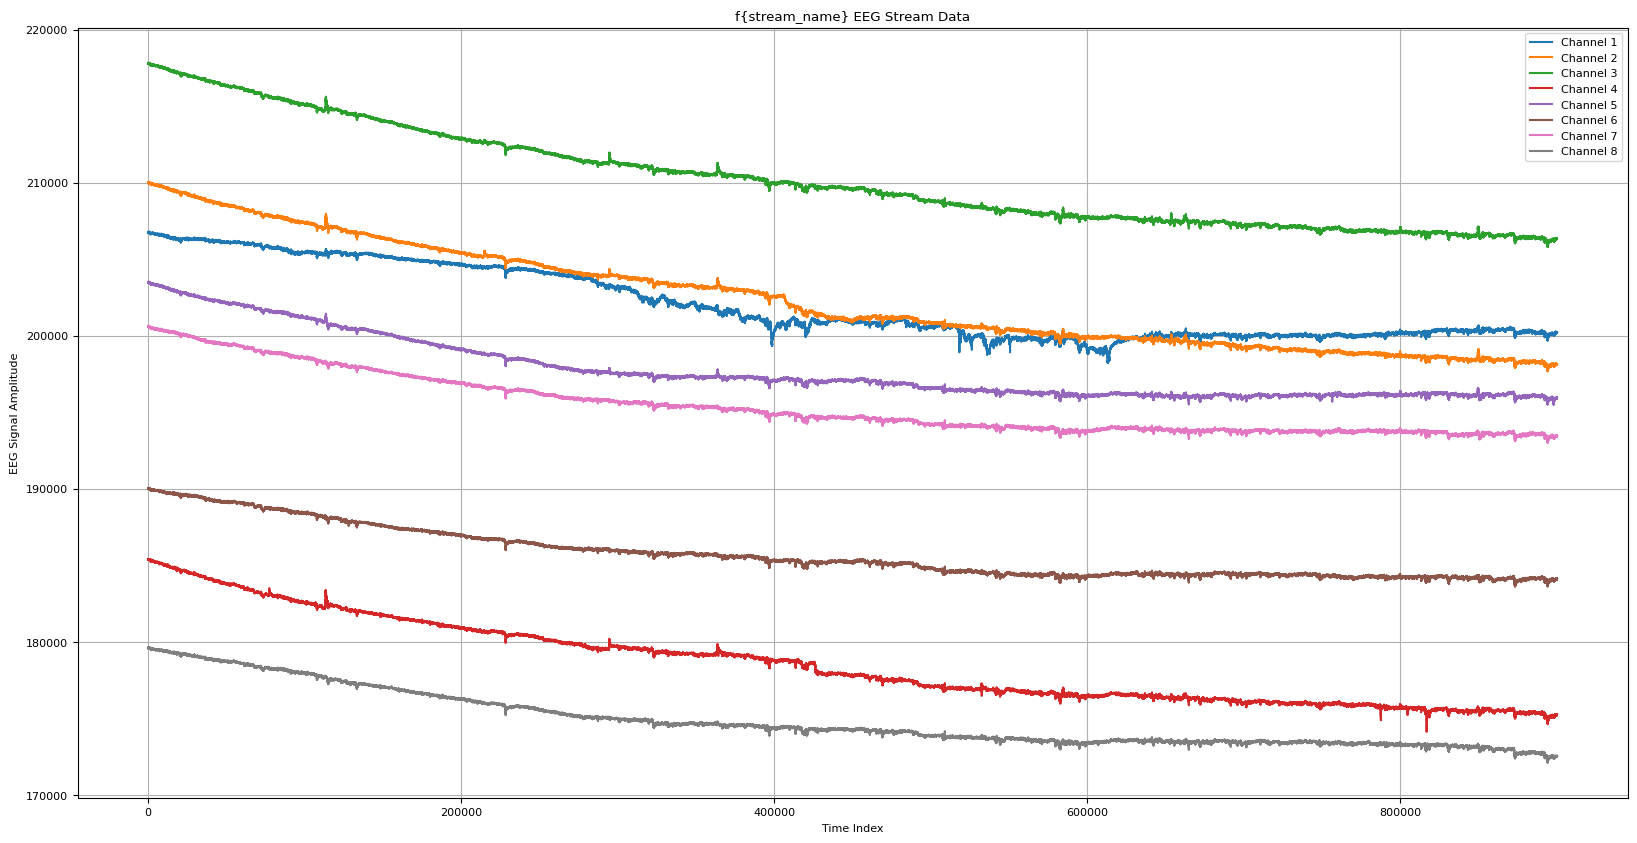

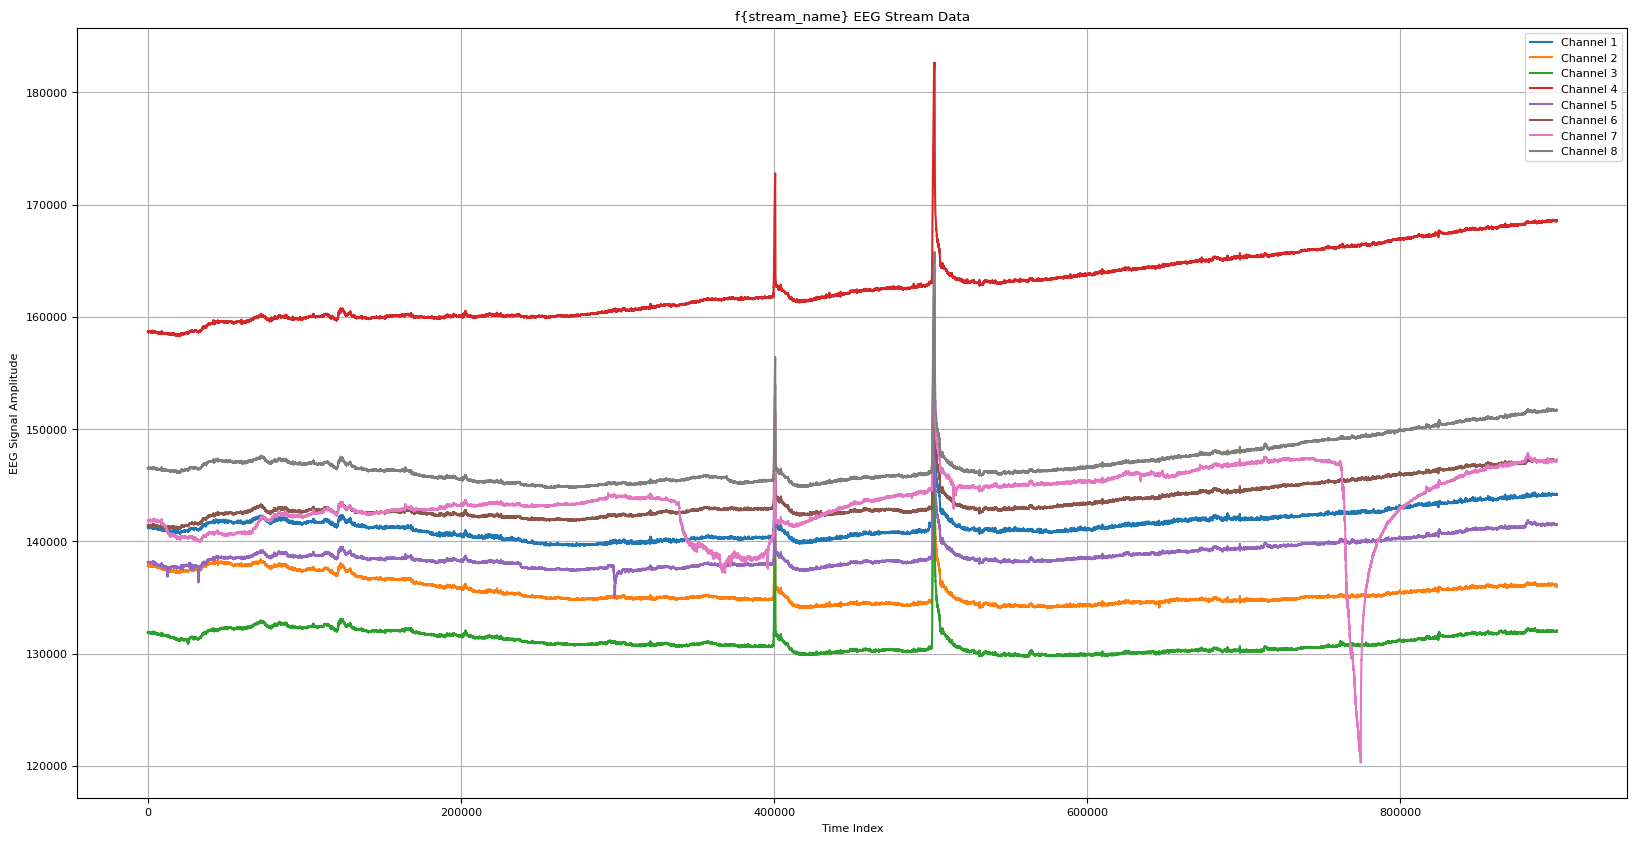

/Users/henryhuang/3rd Year/research/brain-hci/EEG-sync/virtual_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


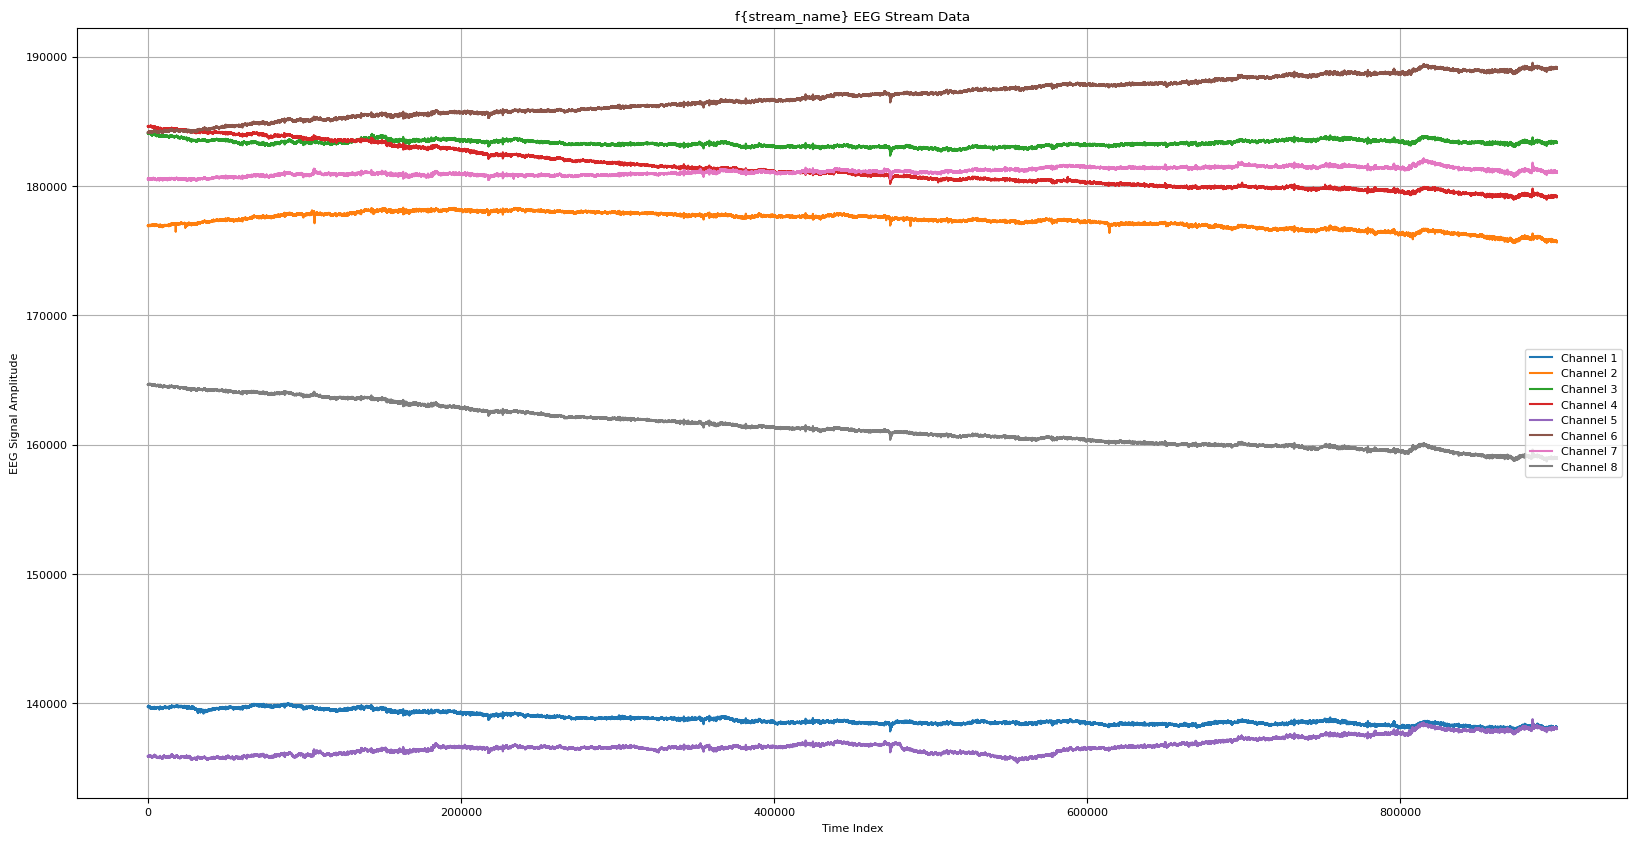

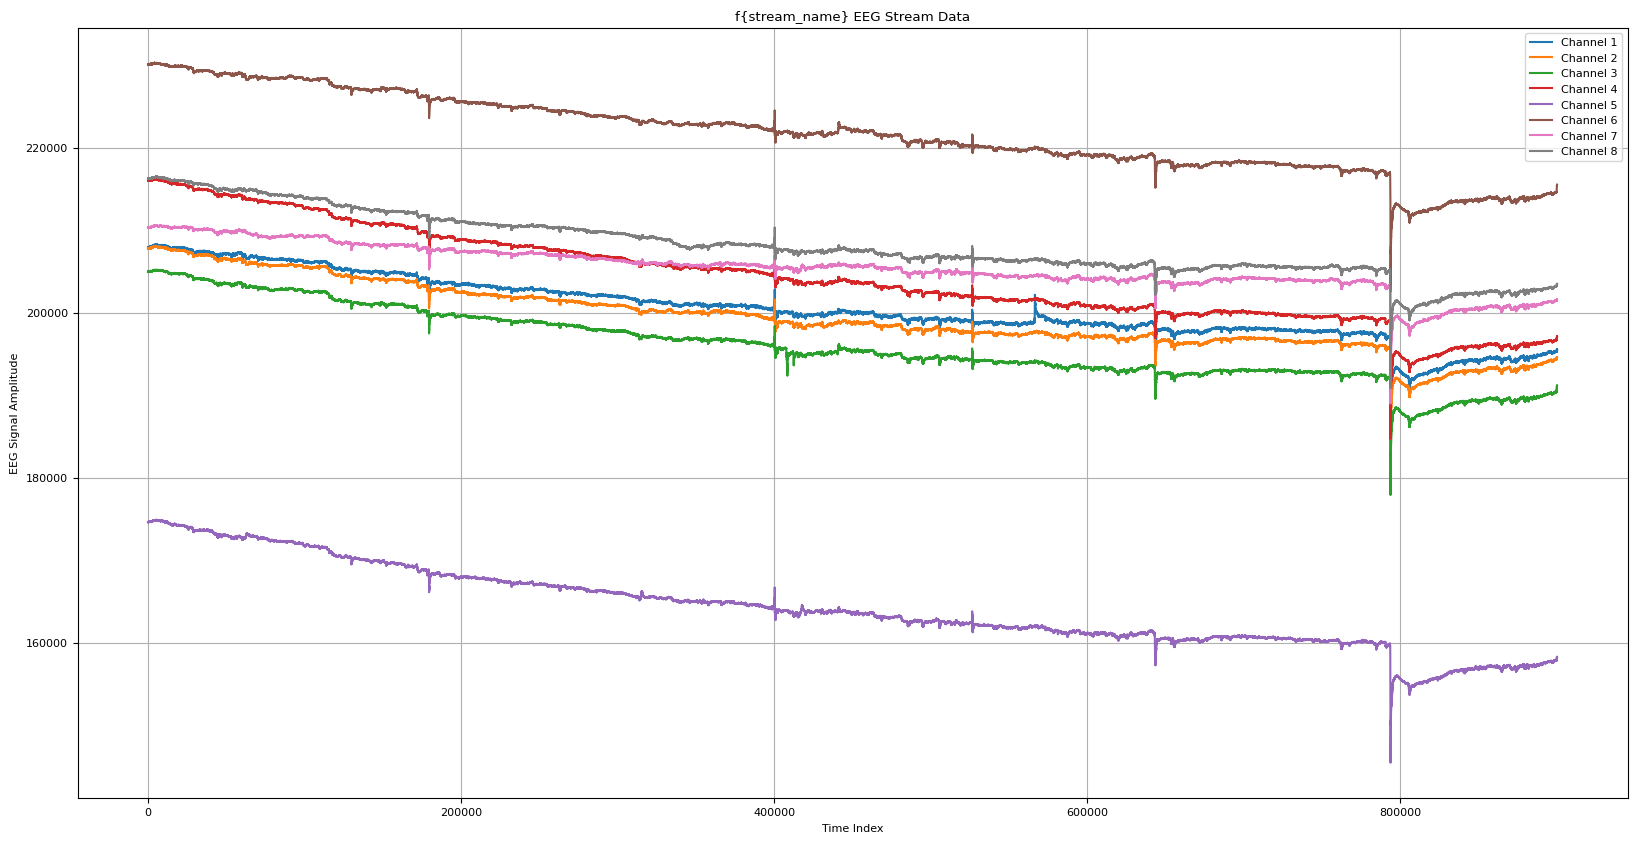

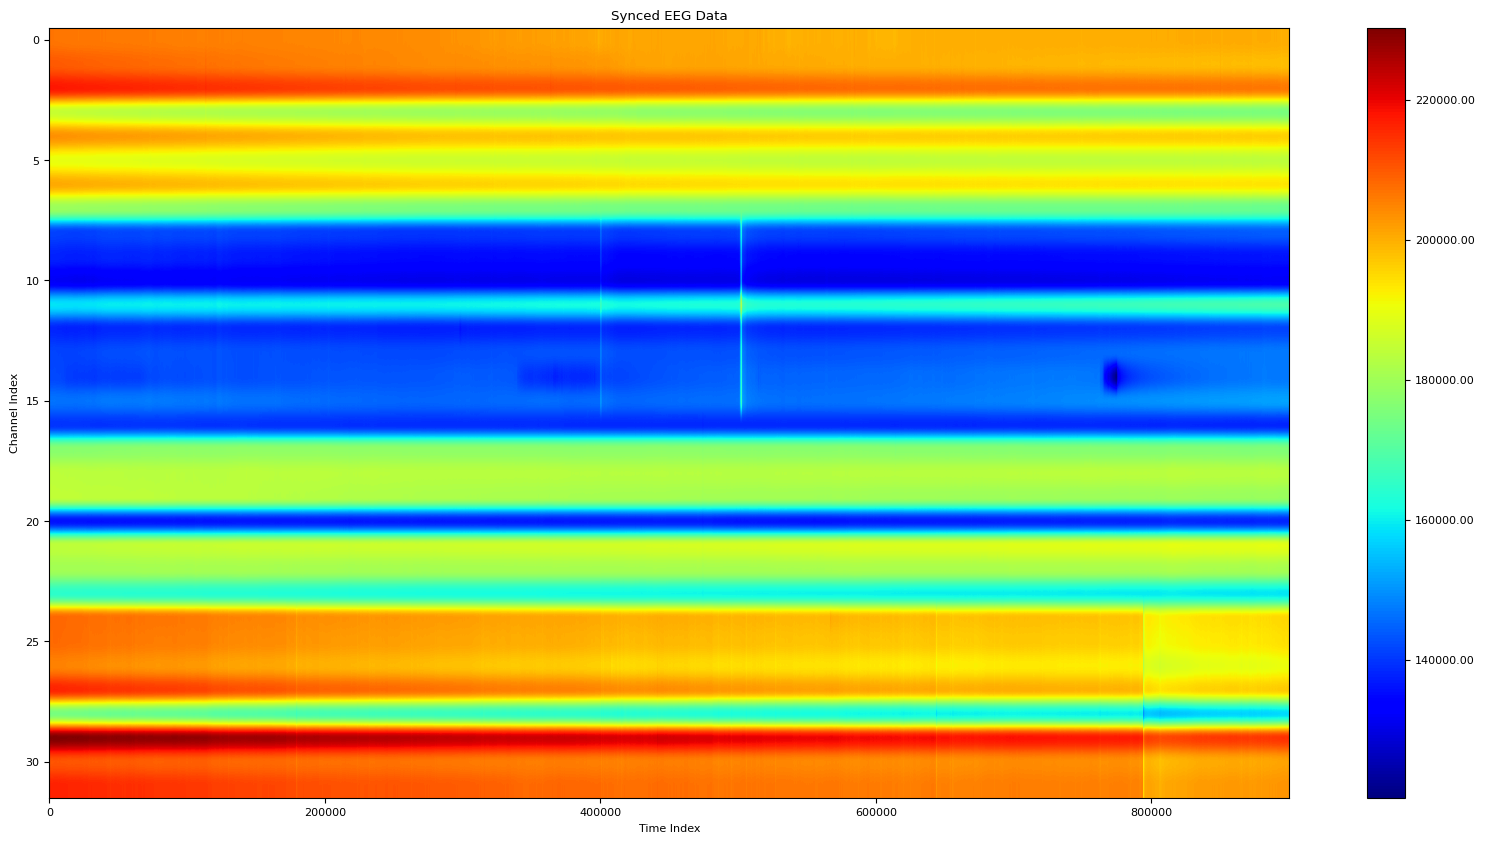

Min: 120280.1875
Max: 230290.015625
Mean: 176148.46210721866
Standard Deviation: 26757.345242972406


In [13]:
import scipy.io

# Disable scientific notation in NumPy globally
np.set_printoptions(suppress=True)

# find the max length of time_series in all EEG streams to establish dimensions for synced EEG streams
max_length = 0

for stream_name in ["Unicorn_HCILab1", "Unicorn_HCILab2", "Unicorn_CSL_Laptop", "Unicorn_CSL_LabPC"]:
    max_length = max(max_length, len(streams[stream_name]["time_series"]))

# Create an np array to hold the synced EEG data with dimensions (max_length, 4 * 8)
synced_EEG_data = np.full((max_length, 4 * 8), np.nan)

# Fill in the synced EEG data
for j, stream_name in enumerate(["Unicorn_HCILab1", "Unicorn_HCILab2", "Unicorn_CSL_Laptop", "Unicorn_CSL_LabPC"]):
    EEG_stream = streams[stream_name]
    
    eeg_stream_data = np.full((len(EEG_stream["time_series"]), 8), np.nan)
    for time_index, eeg_data in enumerate(EEG_stream["time_series"]):
        synced_EEG_data[time_index, j * 8:(j + 1) * 8] = eeg_data[0:8]
        eeg_stream_data[time_index, :] = eeg_data[0:8]
    
    # Visualize the EEG stream data
    time_indices = range(eeg_stream_data.shape[0])
    
    plt.figure(figsize=(20, 10))
    
    # Plot each channel as a separate line
    for channel_idx in range(eeg_stream_data.shape[1]):
        plt.plot(time_indices, eeg_stream_data[:, channel_idx], label=f'Channel {channel_idx+1}')

    plt.title("f{stream_name} EEG Stream Data")
    plt.xlabel("Time Index")
    plt.ylabel("EEG Signal Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Download the EEG data as an .mat file
    scipy.io.savemat(f'{stream_name}.mat', {f'{stream_name}': eeg_stream_data})

# Visualize the synced EEG data
plt.figure(figsize=(20, 10))
plt.imshow(synced_EEG_data.T, aspect='auto', cmap='jet')
plt.colorbar(format='%.2f')  # Ensures color bar does not use scientific notation
plt.title("Synced EEG Data")
plt.xlabel("Time Index")
plt.ylabel("Channel Index")
plt.show()

print("Min:", np.nanmin(synced_EEG_data))
print("Max:", np.nanmax(synced_EEG_data))
print("Mean:", np.nanmean(synced_EEG_data))
print("Standard Deviation:", np.nanstd(synced_EEG_data))

# Download the EEG data as an .mat file
scipy.io.savemat('task_cutoff_EEG_data_2.mat', {'task_cutoff_EEG_data_2': synced_EEG_data})